In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices())
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# smallvggnet.py

# import the necessary packages
import keras
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
import time 
# define our SmallVGGNet class and the build method
# Should I use "ELU" for hidden layer as better for image classification?
class SmallVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model along with the input shape to be "channels last" and the channels dimension/depth itself
        model = Sequential()   # (i.e. TensorFlow ordering)
        inputShape = (height, width, depth)
        chanDim = -1

        # if we are using "channels first", update the input shape and channels dimension
        if K.image_data_format() == "channels_first":   # (i.e. Theano ordering)
            inputShape = (depth, height, width)
            chanDim = 1

        # CONV => RELU => POOL layer set              # first CONV layer has 32 filters of size 3x3
        model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))                 # ReLU (Rectified Linear Unit) activation function
        model.add(BatchNormalization(axis=chanDim))   # normalize activations of input volume before passing to next layer
        model.add(MaxPooling2D(pool_size=(2, 2)))     # progressively reduce spatial size (width and height) of input 
        model.add(Dropout(0.25))                      # disconnecting random neurons between layers, reduce overfitting

        # (CONV => RELU) * 2 => POOL layer set          # filter dimensions remain the same (3x3)
        model.add(Conv2D(64, (3, 3), padding="same"))   # increase total number of filters learned (from 32 to 64)
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # (CONV => RELU) * 3 => POOL layer set
        model.add(Conv2D(128, (3, 3), padding="same"))   # total number of filters learned by CONV layers has doubled (128)
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # first (and only) set of fully connected layer (FC) => RELU layers
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model

In [4]:
# import the necessary packages
# from pyimagesearch.smallvggnet import SmallVGGNet   # "smallvggnet.py" file is in "pyimagesearch" folder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from imutils import paths
import matplotlib as plt
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
import pickle
import cv2
import os
import warnings
warnings.filterwarnings("ignore")

In [5]:
# initialize the data and labels
print("[INFO] loading images...")
images = []
labels = []

# grab the image paths and randomly shuffle them
imagePaths = sorted(list(paths.list_images('C:/Users/thanawin/Desktop/Deep/detect/train')))
random.seed(42)
random.shuffle(imagePaths)

# loop over the input images
for imagePath in imagePaths:
    # load the image, resize it to 64x64 pixels (the required input spatial dimensions of SmallVGGNet), 
    # and store the image in the data list
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (64, 64))   # we are not flattening our data for neural network, because it is convolutional
    images.append(image)

    # extract the class label from the image path and update the labels list
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)

# scale the raw pixel intensities to the range [0, 1]
images = np.array(images, dtype="float") / 255.0
labels = np.array(labels)

print('done')

[INFO] loading images...
done


In [6]:
# partition the data into 75% training and 25% validation, try 80/20 later
(trainX, testX, trainY, testY) = train_test_split(images,labels, test_size=0.2, random_state=42)

# before transformation
trainY

array(['surprise', 'anger', 'surprise', ..., 'hapiness', 'fear',
       'surprise'], dtype='<U8')

In [7]:
# convert the labels from integers to vectors 
# (for 2-class, binary classification you should use Keras' to_categorical function)
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

# after transformation
trainY

array([[0, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [8]:
import tensorflow as tf
# Construct & initialize the image data generator for data augmentation
# Image augmentation allows us to construct “additional” training data from our existing training data 
# by randomly rotating, shifting, shearing, zooming, and flipping. This is to avoid overfitting.
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

# initialize our VGG-like Convolutional Neural Network
model = SmallVGGNet.build(width=64, height=64, depth=3, classes=len(lb.classes_))

# compile & train model
# initialize our initial learning rate, # of epochs to train for, and batch size
INIT_LR = 0.01
EPOCHS = 75
BS = 32

# initialize the model and optimizer (you'll want to use binary_crossentropy for 2-class classification)
print("[INFO] training network...")
opt = SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])



[INFO] training network...


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0

In [10]:
# train the network
H = model.fit_generator( aug.flow(trainX, trainY, batch_size=BS),
                        validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS, epochs=EPOCHS,
                        callbacks=[keras.callbacks.EarlyStopping(patience=11, verbose=1, restore_best_weights=True),
                                   keras.callbacks.ReduceLROnPlateau(factor=.5, patience=4, verbose=1)] )

Epoch 1/75
511/511 [==============================] - 41s 37ms/step - loss: 2.2436 - accuracy: 0.2534 - val_loss: 2.0548 - val_accuracy: 0.2601
Epoch 2/75
511/511 [==============================] - 18s 36ms/step - loss: 1.7723 - accuracy: 0.3255 - val_loss: 1.6090 - val_accuracy: 0.3843
Epoch 3/75
511/511 [==============================] - 18s 35ms/step - loss: 1.6437 - accuracy: 0.3654 - val_loss: 1.4597 - val_accuracy: 0.4468
Epoch 4/75
511/511 [==============================] - 18s 35ms/step - loss: 1.5752 - accuracy: 0.3971 - val_loss: 1.4510 - val_accuracy: 0.4520
Epoch 5/75
511/511 [==============================] - 18s 35ms/step - loss: 1.5250 - accuracy: 0.4124 - val_loss: 1.3956 - val_accuracy: 0.4833
Epoch 6/75
511/511 [==============================] - 18s 35ms/step - loss: 1.4827 - accuracy: 0.4255 - val_loss: 1.2946 - val_accuracy: 0.5045
Epoch 7/75
511/511 [==============================] - 18s 35ms/step - loss: 1.4491 - accuracy: 0.4455 - val_loss: 1.2818 - val_accuracy:

511/511 [==============================] - 18s 35ms/step - loss: 1.0568 - accuracy: 0.6097 - val_loss: 0.8624 - val_accuracy: 0.6788
Epoch 56/75
511/511 [==============================] - 18s 35ms/step - loss: 1.0552 - accuracy: 0.6093 - val_loss: 0.8537 - val_accuracy: 0.6795
Epoch 57/75
511/511 [==============================] - 18s 35ms/step - loss: 1.0524 - accuracy: 0.6124 - val_loss: 0.8857 - val_accuracy: 0.6729
Epoch 58/75
511/511 [==============================] - 18s 35ms/step - loss: 1.0467 - accuracy: 0.6085 - val_loss: 0.8494 - val_accuracy: 0.6820

Epoch 00058: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.
Epoch 59/75
511/511 [==============================] - 18s 35ms/step - loss: 1.0499 - accuracy: 0.6074 - val_loss: 0.8591 - val_accuracy: 0.6788
Epoch 60/75
511/511 [==============================] - 18s 35ms/step - loss: 1.0424 - accuracy: 0.6120 - val_loss: 0.8568 - val_accuracy: 0.6798
Epoch 61/75
511/511 [==============================] - 18s 35

In [11]:
# train the neural network on training data set
# batch_size (32) controls the size of each group of data to pass through the network. 
# Larger GPUs would be able to accommodate larger batch sizes (eg. 64)
time1 = time.time()   # to measure time taken
H = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=EPOCHS, batch_size=BS)
print('Time taken: {:.1f} seconds'.format(time.time() - time1))   # to measure time taken

Epoch 1/75
512/512 [==============================] - 11s 21ms/step - loss: 0.9137 - accuracy: 0.6639 - val_loss: 0.8657 - val_accuracy: 0.6773
Epoch 2/75
512/512 [==============================] - 10s 20ms/step - loss: 0.9144 - accuracy: 0.6612 - val_loss: 0.8635 - val_accuracy: 0.6798
Epoch 3/75
512/512 [==============================] - 10s 20ms/step - loss: 0.9088 - accuracy: 0.6647 - val_loss: 0.8577 - val_accuracy: 0.6786
Epoch 4/75
512/512 [==============================] - 10s 20ms/step - loss: 0.9065 - accuracy: 0.6666 - val_loss: 0.8585 - val_accuracy: 0.6800
Epoch 5/75
512/512 [==============================] - 10s 20ms/step - loss: 0.9000 - accuracy: 0.6714 - val_loss: 0.8523 - val_accuracy: 0.6820
Epoch 6/75
512/512 [==============================] - 10s 20ms/step - loss: 0.9028 - accuracy: 0.6649 - val_loss: 0.8488 - val_accuracy: 0.6837
Epoch 7/75
512/512 [==============================] - 10s 20ms/step - loss: 0.9020 - accuracy: 0.6699 - val_loss: 0.8512 - val_accuracy:

512/512 [==============================] - 11s 21ms/step - loss: 0.8697 - accuracy: 0.6809 - val_loss: 0.8135 - val_accuracy: 0.6981
Epoch 58/75
512/512 [==============================] - 10s 20ms/step - loss: 0.8684 - accuracy: 0.6815 - val_loss: 0.8108 - val_accuracy: 0.6984
Epoch 59/75
512/512 [==============================] - 10s 20ms/step - loss: 0.8763 - accuracy: 0.6768 - val_loss: 0.8095 - val_accuracy: 0.6991
Epoch 60/75
512/512 [==============================] - 10s 20ms/step - loss: 0.8719 - accuracy: 0.6781 - val_loss: 0.8086 - val_accuracy: 0.6991
Epoch 61/75
512/512 [==============================] - 10s 20ms/step - loss: 0.8733 - accuracy: 0.6796 - val_loss: 0.8066 - val_accuracy: 0.6998
Epoch 62/75
512/512 [==============================] - 10s 20ms/step - loss: 0.8791 - accuracy: 0.6777 - val_loss: 0.8071 - val_accuracy: 0.7003
Epoch 63/75
512/512 [==============================] - 10s 20ms/step - loss: 0.8689 - accuracy: 0.6796 - val_loss: 0.8080 - val_accuracy: 0.70

In [12]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

       anger       0.60      0.61      0.61       793
     disgust       0.68      0.72      0.70       485
        fear       0.64      0.32      0.42       464
    hapiness       0.89      0.92      0.90       642
     neutral       0.63      0.87      0.73       476
         sad       0.62      0.53      0.57       555
    surprise       0.79      0.88      0.83       676

    accuracy                           0.70      4091
   macro avg       0.69      0.69      0.68      4091
weighted avg       0.70      0.70      0.69      4091



In [13]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(testY, predictions)

# # Print confusion matrix heatmap for SmallVGGNet_CNN_model
# knn_confusion = confusion_matrix(testY, predictions)
# plt.figure(dpi=150)
# sns.heatmap(knn_confusion, cmap=plt.cm.Blues, annot=True, square=True,
#            xticklabels=['Cat', 'Dog', 'Panda'],
#            yticklabels=['Cat', 'Dog', 'Panda'] )
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('SmallVGGNet_CNN confusion matrix');

ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

In [14]:
# visualize confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.ylabel('Actual label', weight='bold')
plt.xlabel('Predicted label', weight='bold')

thresh = cm.max() / 2.

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

tick_marks = np.arange(len(iris.target_names))
plt.xticks(tick_marks, iris.target_names, rotation=0)
plt.yticks(tick_marks, iris.target_names)

plt.show()

NameError: name 'cm' is not defined

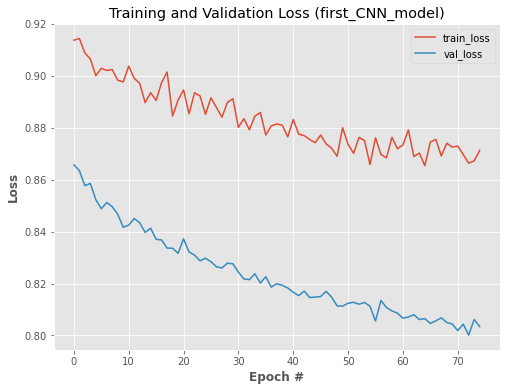

In [15]:
# plot the training/validation loss
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize = [8,6])
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training and Validation Loss (first_CNN_model)")
plt.xlabel("Epoch #", weight='bold')
plt.ylabel("Loss", weight='bold')
plt.legend()

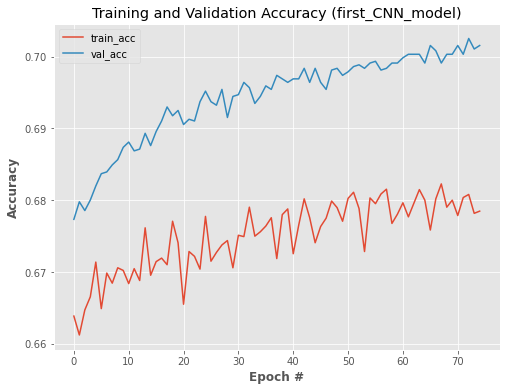

In [16]:
# plot the training/validation accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize = [8,6])
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training and Validation Accuracy (first_CNN_model)")
plt.xlabel("Epoch #", weight='bold')
plt.ylabel("Accuracy", weight='bold')
plt.legend()

In [17]:
# save the model and label binarizer to disk
print("[INFO] serializing network and label binarizer...")
model.save("first_CNN_model")
f = open("first_CNN_model_label_bin", "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] serializing network and label binarizer...
INFO:tensorflow:Assets written to: first_CNN_model\assets


#TEST

In [ ]:
# make prediction
# import the necessary packages
from keras.models import load_model
# import argparse
import pickle
import cv2

# load the input image and resize it to the target spatial dimensions
width = 64
height = 64
image = cv2.imread("/content/drive/MyDrive/Colab Notebooks/images2/happy/Aaron_Guiel_0001.jpg")
output = image.copy()
image = cv2.resize(image, (width, height))

# scale the pixel values to [0, 1]
image = image.astype("float") / 255.0

# when working with a CNN: don't flatten the image, simply add the batch dimension
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

# # load the model and label binarizer
# print("[INFO] loading network and label binarizer...")
# model = load_model('first_CNN_model')
# lb = pickle.loads(open("first_CNN_model_label_bin", "rb").read())

# make a prediction on the image
preds = model.predict(image)

# find the class label index with the largest corresponding probability
i = preds.argmax(axis=1)[0]
label = lb.classes_[i]

# draw the class label + probability on the output image
text = "{}: {:.1f}%".format(label, preds[0][i] * 100)
cv2.putText(output, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)

# show the output image
cv2.imshow("Image", output)
cv2.waitKey(0)   # Delay in milliseconds. 0 is the special value that means “forever”, until you close the image window

In [ ]:
# plot the prediction probability for each category
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("ggplot")
plt.figure(figsize = [10,5])   # [width, height]

x = [ lb.classes_[0], lb.classes_[1], lb.classes_[2], lb.classes_[3], lb.classes_[4], lb.classes_[5], lb.classes_[6] ]
y = [ preds[0][0], preds[0][1], preds[0][2], preds[0][3], preds[0][4], preds[0][5], preds[0][6] ]
plt.barh(x, y, color='violet')

ticks_x = np.linspace(0, 1, 11)   # (start, end, number of ticks)
plt.xticks(ticks_x, fontsize=10, family='fantasy', color='black')
plt.yticks( size=15, color='navy' )
for i, v in enumerate(y):
    plt.text(v, i, "  "+str((v*100).round(1))+"%", color='blue', va='center', fontweight=None)

plt.title('Prediction Probability', family='serif', fontsize=15, style='italic', weight='bold', color='olive', loc='center', rotation=0)
plt.xlabel('Probability', fontsize=12, weight='bold', color='blue')
plt.ylabel('Category', fontsize=12, weight='bold', color='indigo')

#Test set

In [ ]:
# initialize the data and labels
print("[INFO] loading images...")
images = []
labels = []

# grab the image paths and randomly shuffle them
imagePaths = sorted(list(paths.list_images('test set')))
random.seed(42)
random.shuffle(imagePaths)

# loop over the input images
for imagePath in imagePaths:
    # load the image, resize it to 64x64 pixels (the required input spatial dimensions of SmallVGGNet), 
    # and store the image in the data list
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (64, 64))   # we are not flattening our data for neural network, because it is convolutional
    images.append(image)

    # extract the class label from the image path and update the labels list
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)

# scale the raw pixel intensities to the range [0, 1]
images = np.array(images, dtype="float") / 255.0
labels = np.array(labels)

print('done')

In [ ]:
X = images
y = labels

In [ ]:
# convert the labels from integers to vectors 
# (for 2-class, binary classification you should use Keras' to_categorical function)
lb = LabelBinarizer()
y = lb.transform(y)


In [ ]:
score = model.evaluate(X, y, verbose=0)
print("Loss is", score[0])
print("Accuracy score is", score[1])